In [1]:
import json
import os
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

DATA_PATH = "../data/cleaned/diabetes_model_ready.parquet"
FEATURE_SPEC_PATH = "../data/processed/feature_spec.json"
MODEL_PATH = "../results/models/final_logreg_grid.joblib"

df = pd.read_parquet(DATA_PATH)

with open(FEATURE_SPEC_PATH, "r", encoding="utf-8") as f:
    feature_spec = json.load(f)

target = feature_spec["target"]
num_features = feature_spec["numeric_features"]
cat_features = feature_spec["categorical_features"]

X = df[num_features + cat_features]
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = joblib.load(MODEL_PATH)

os.makedirs("../results/visualizations", exist_ok=True)
os.makedirs("../results/metrics", exist_ok=True)

print("Loaded model:", MODEL_PATH)
print("Test shape:", X_test.shape)


Loaded model: ../results/models/final_logreg_grid.joblib
Test shape: (154, 12)


In [2]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

y_pred = model.predict(X_test)

# For AUC we need scores/probabilities
y_proba = model.predict_proba(X_test)[:, 1]

metrics = {
    "accuracy": float(accuracy_score(y_test, y_pred)),
    "precision": float(precision_score(y_test, y_pred, zero_division=0)),
    "recall": float(recall_score(y_test, y_pred, zero_division=0)),
    "f1": float(f1_score(y_test, y_pred, zero_division=0)),
    "roc_auc": float(roc_auc_score(y_test, y_proba)),
}

metrics_df = pd.DataFrame([metrics]).round(4)
print(metrics_df)

metrics_df.to_csv("../results/metrics/test_metrics.csv", index=False)
print("Saved: ../results/metrics/test_metrics.csv")


   accuracy  precision  recall      f1  roc_auc
0    0.7532     0.6212  0.7593  0.6833   0.8256
Saved: ../results/metrics/test_metrics.csv


In [3]:
from sklearn.metrics import classification_report

report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).T
report_df = report_df.round(4)

report_df.to_csv("../results/metrics/classification_report.csv", index=True)
print("Saved: ../results/metrics/classification_report.csv")


display(report_df.loc[["0", "1", "accuracy", "macro avg", "weighted avg"]])


Saved: ../results/metrics/classification_report.csv


,precision,recall,f1-score,support
0,0.8523,0.7500,0.7979,100.0000
1,0.6212,0.7593,0.6833,54.0000
accuracy,0.7532,0.7532,0.7532,0.7532
macro avg,0.7367,0.7546,0.7406,154.0000
weighted avg,0.7713,0.7532,0.7577,154.0000


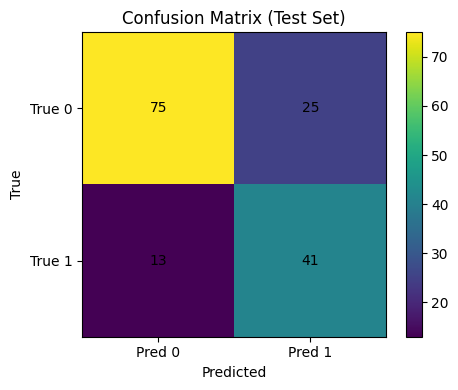

Saved: ../results/visualizations/confusion_matrix.png


In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
plt.imshow(cm)
plt.colorbar()

plt.xticks([0, 1], ["Pred 0", "Pred 1"])
plt.yticks([0, 1], ["True 0", "True 1"])

# Annotate cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()

plt.savefig("../results/visualizations/confusion_matrix.png", dpi=200)
plt.show()

print("Saved: ../results/visualizations/confusion_matrix.png")


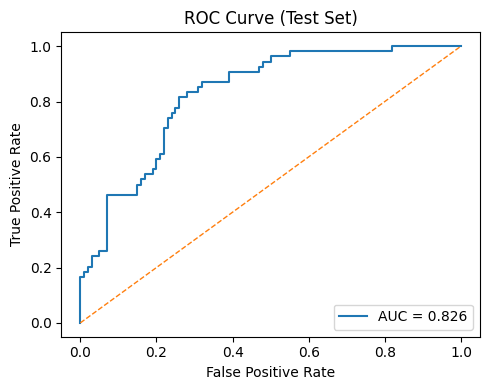

Saved: ../results/visualizations/roc_curve.png


In [5]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {metrics['roc_auc']:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig("../results/visualizations/roc_curve.png", dpi=200)
plt.show()

print("Saved: ../results/visualizations/roc_curve.png")
